# Benchmarking Results

In [13]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

pd.options.mode.chained_assignment = None

### 1. Load, Summarize, Insert

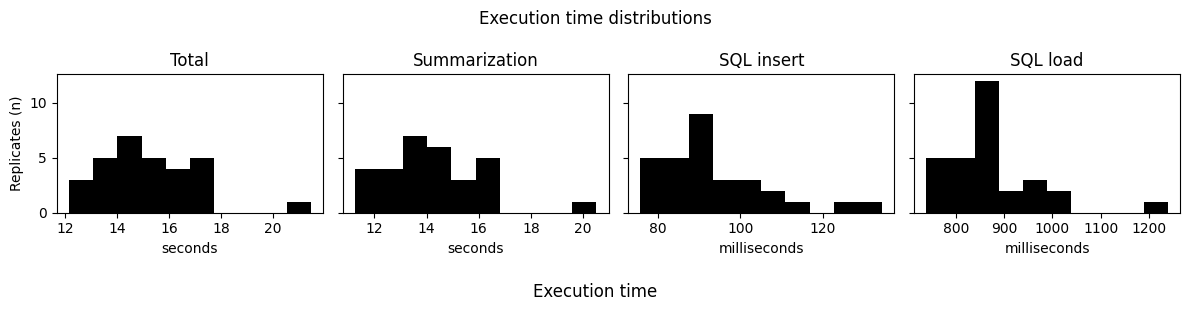

,replicate,num_abstracts,total_replicate_time,total_summarization_time,total_insert_time,total_loading_time,mean_total_time,mean_summarization_time,mean_insert_time,mean_loading_time
0,1,5,81.024608,74.159446,0.672012,6.193149,16.204922,14.831889,0.134402,1.238630
1,2,5,87.608085,82.806621,0.466438,4.335026,17.521617,16.561324,0.093288,0.867005
2,3,5,75.511175,70.447547,0.538895,4.524733,15.102235,14.089509,0.107779,0.904947
3,4,5,63.350354,58.682924,0.402112,4.265318,12.670071,11.736585,0.080422,0.853064
4,5,5,85.457751,80.822233,0.494642,4.140875,17.091550,16.164447,0.098928,0.828175


In [14]:
def load_summarize_insert_plot(datafile):
    
    data = pd.read_csv(datafile)

    titles = ['Total', 'Summarization', 'SQL insert', 'SQL load']
    data_types = ['mean_total_time', 'mean_summarization_time', 'mean_insert_time', 'mean_loading_time']
    xlabels = ['seconds', 'seconds', 'milliseconds', 'milliseconds']
    xaxis_scales = [1, 1, 10**3, 10**3]

    fig, axs = plt.subplots(1, 4, figsize=(12, 3), sharey=True, tight_layout=True)

    fig.suptitle('Execution time distributions')
    fig.supxlabel('Execution time')

    axs_num = 0

    for title, data_type, xlabel, xaxis_scale in zip(titles, data_types, xlabels, xaxis_scales):

        axs[axs_num].set_title(title)
        axs[axs_num].set_xlabel(xlabel)
        axs[axs_num].xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
        axs[axs_num].hist(
            data[data_type] * xaxis_scale,
            histtype='stepfilled', 
            cumulative=0,
            color='black'
        )

        axs_num += 1

    axs[0].set_ylabel('Replicates (n)')

    return data, plt

data, plt = load_summarize_insert_plot('../benchmarks/load_summarize_insert/results.csv')

plt.show()
data.head()


### 2. Huggingface Device Map

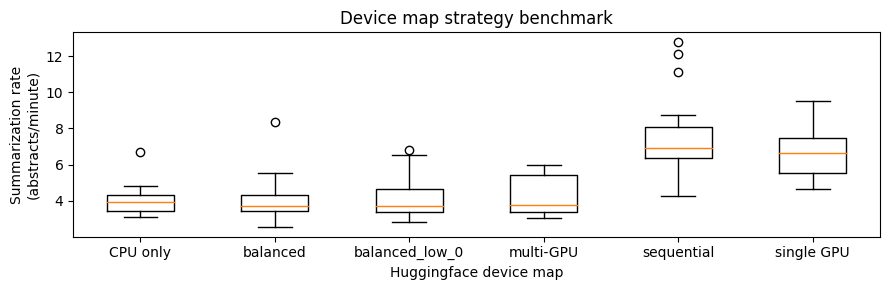

,abstract,device map strategy,summarization time (sec.),summarization rate (abstracts/sec.),summarization rate (abstracts/min.)
0,1,CPU only,19.163196,0.052183,3.131002
1,2,CPU only,15.579454,0.064187,3.851226
2,3,CPU only,15.299519,0.065362,3.921692
3,4,CPU only,19.429485,0.051468,3.088090
4,5,CPU only,15.677886,0.063784,3.827047


In [15]:
def device_map_plot(datafile):

    data = pd.read_csv(datafile)
    data['summarization rate (abstracts/min.)'] = data['summarization rate (abstracts/sec.)'] * 60

    wide_data = data.pivot(index='abstract', columns='device map strategy', values='summarization rate (abstracts/min.)')

    fig, axs = plt.subplots(1, 1, figsize=(9, 3), tight_layout=True)

    axs.set_title('Device map strategy benchmark')
    axs.set_xlabel('Huggingface device map')
    axs.set_ylabel('Summarization rate\n(abstracts/minute)')
    axs.boxplot(wide_data, labels=wide_data.columns)

    return data, plt

data, plt = device_map_plot('../benchmarks/huggingface_device_map/results.csv')

plt.show()
data.head()

### 3. Parallel Summarization

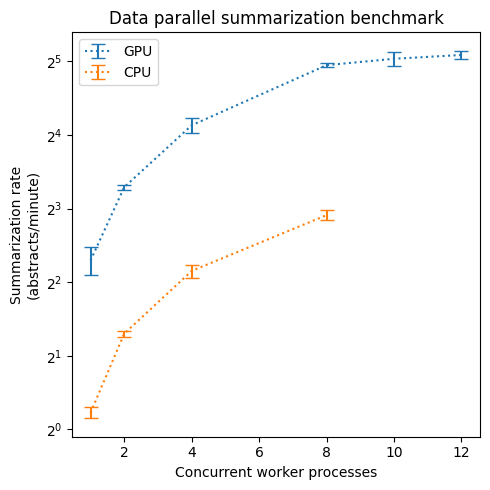

,abstracts,abstracts per worker,replicate,batches,device,workers,summarization time (sec.),summarization rate (abstracts/sec.),summarization rate (abstracts/min.)
0,3,3,1,3,GPU,1,30.150212,0.099502,5.970107
1,3,3,2,3,GPU,1,36.425715,0.082359,4.941564
2,3,3,3,3,GPU,1,37.477932,0.080047,4.802826
3,3,3,4,3,GPU,1,39.440129,0.076065,4.563880
4,3,3,5,3,GPU,1,42.265013,0.070981,4.258842


In [16]:
def parallel_summarization_plot(datafile):

    data = pd.read_csv(datafile)

    OOM_columns = [
        'summarization time (sec.)',
        'summarization rate (abstracts/sec.)'
    ]

    OOM = data[data['summarization time (sec.)'] == 'OOM']
    OOM = OOM[['device', 'workers']]
    OOM_conditions = OOM.to_numpy().tolist()

    for OOM_column in OOM_columns:
        for condition in OOM_conditions:

            data[OOM_column].loc[
                (data['device'] == condition[0]) &
                (data['workers'] == condition[1])
            ] = np.nan

    data.dropna(inplace=True)

    data['summarization time (sec.)'] = data['summarization time (sec.)'].astype(float)
    data['summarization rate (abstracts/sec.)'] = data['summarization rate (abstracts/sec.)'].astype(float)

    data['summarization rate (abstracts/min.)'] = data['summarization rate (abstracts/sec.)'] * 60

    devices = ['GPU', 'CPU']

    fig, axs = plt.subplots(1, 1, figsize=(5, 5), tight_layout=True)

    axs.set_title('Data parallel summarization benchmark')
    axs.set_xlabel('Concurrent worker processes')
    axs.set_ylabel('Summarization rate\n(abstracts/minute)')
    axs.set_yscale('log', base=2)
    axs.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))

    for device in devices:

        plot_data = data[data['device'] == device]

        mean = plot_data.groupby(['device', 'workers']).mean()
        mean.reset_index(inplace=True)
        
        std = plot_data.groupby(['device', 'workers']).std()
        std.reset_index(inplace=True)

        axs.errorbar(
            mean['workers'], 
            mean['summarization rate (abstracts/min.)'], 
            yerr=std['summarization rate (abstracts/min.)'],
            capsize=5,
            label=device,
            linestyle='dotted'
        )

    plt.legend(loc='best')

    return data, plt

data, plt = parallel_summarization_plot('../benchmarks/parallel_summarization/results.csv')

plt.show()
data.head()

### 4. Model quantization

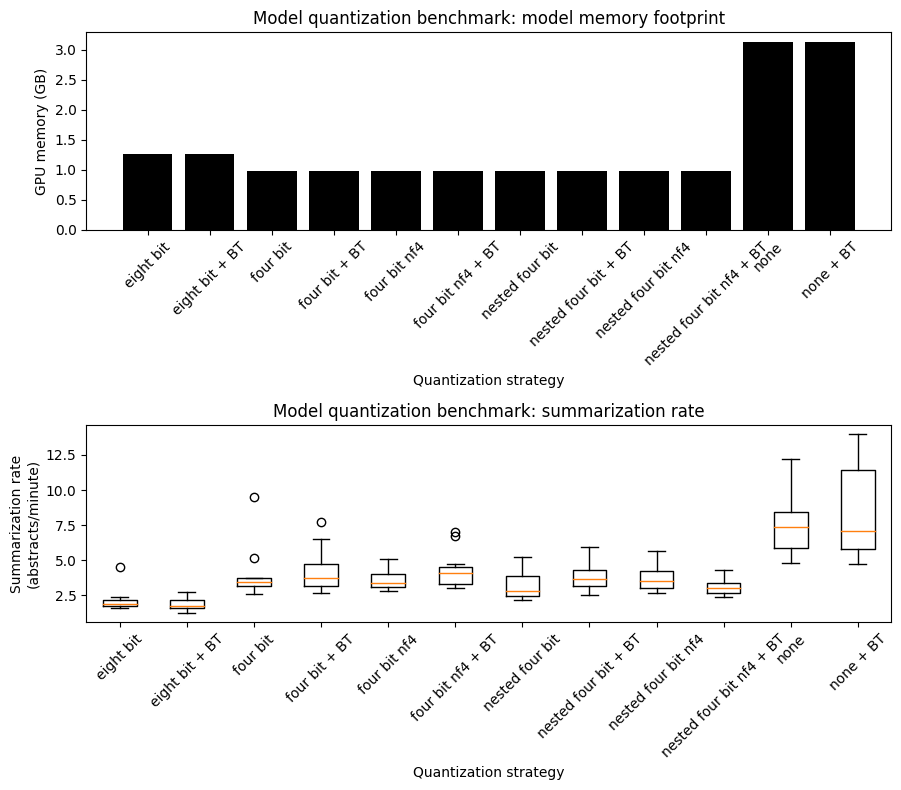

,abstract,quantization strategy,summarization time (sec.),summarization rate (abstracts/sec.),model GPU memory footprint (bytes),max memory allocated (bytes),summarization rate (abstracts/min.),model GPU memory footprint (GB)
0,1,none,10.884255,0.091876,3132600320,4757159936,5.512550,3.1326
1,2,none,7.112705,0.140593,3132600320,3479068672,8.435609,3.1326
2,3,none,4.912107,0.203579,3132600320,3463340032,12.214716,3.1326
3,4,none,8.217777,0.121687,3132600320,3488113152,7.301244,3.1326
4,5,none,8.014868,0.124768,3132600320,3486540288,7.486087,3.1326


In [17]:
def model_quantization_plot(datafile):

    data = pd.read_csv(datafile)
    data['summarization rate (abstracts/min.)'] = data['summarization rate (abstracts/sec.)'] * 60
    data['model GPU memory footprint (GB)'] = data['model GPU memory footprint (bytes)'] / 10 ** 9

    fig, axs = plt.subplots(2, 1, figsize=(9, 8), tight_layout=True)

    mean_memory_footprint_data = data[['quantization strategy', 'model GPU memory footprint (GB)']].groupby('quantization strategy').mean()

    axs[0].set_title('Model quantization benchmark: model memory footprint')
    axs[0].set_xlabel('Quantization strategy')
    axs[0].set_ylabel('GPU memory (GB)')
    axs[0].tick_params(axis='x', labelrotation=45)
    axs[0].bar(
        x=mean_memory_footprint_data.index, 
        height=mean_memory_footprint_data['model GPU memory footprint (GB)'],
        color='black'
    )

    rate_data = data[['abstract', 'quantization strategy', 'summarization rate (abstracts/min.)']]
    rate_data = data.pivot(index='abstract', columns='quantization strategy', values='summarization rate (abstracts/min.)')

    axs[1].set_title('Model quantization benchmark: summarization rate')
    axs[1].set_xlabel('Quantization strategy')
    axs[1].set_ylabel('Summarization rate\n(abstracts/minute)')
    axs[1].tick_params(axis='x', labelrotation=45)
    axs[1].boxplot(rate_data, labels=rate_data.columns)

    return data, plt

data, plt = model_quantization_plot('../benchmarks/model_quantization/results.csv')

plt.show()
data.head()

### 5. Batched summarization

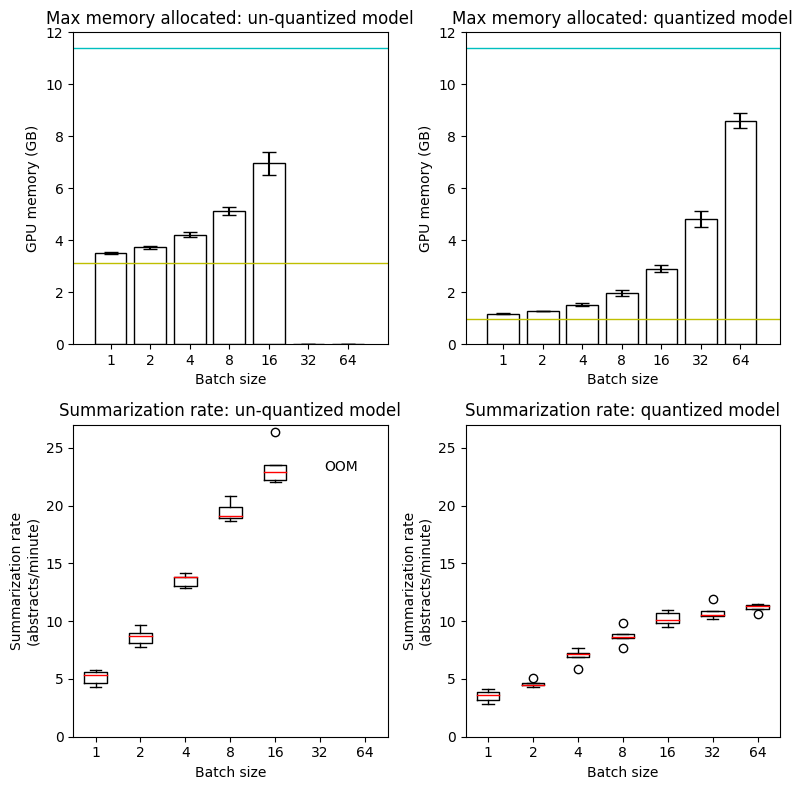

,abstracts,replicate,batches,batch size,quantization,summarization time (sec.),summarization rate (abstracts/sec.),model GPU memory footprint (bytes),max memory allocated (bytes),summarization rate (abstracts/min.),max memory allocated (GB)
0,3,1,3,1,none,42.157302,0.071162,3132600320,3506201600,4.269723,3.506202
1,3,2,3,1,none,38.400090,0.078125,3132600320,3503972864,4.687489,3.503973
2,3,3,3,1,none,33.716630,0.088977,3132600320,3499254272,5.338612,3.499254
3,3,4,3,1,none,31.377111,0.095611,3132600320,3491389952,5.736666,3.491390
4,3,5,3,1,none,32.319329,0.092824,3132600320,3515376640,5.569423,3.515377


In [18]:
def batch_summarization_plot(datafile):

    data = pd.read_csv(datafile)
    data['summarization rate (abstracts/sec.)'] = data['summarization rate (abstracts/sec.)'].astype(str)

    OOM_columns = [
        'summarization time (sec.)',
        'summarization rate (abstracts/sec.)',
        'model GPU memory footprint (bytes)',
        'max memory allocated (bytes)'
    ]

    OOM = data[data['summarization time (sec.)'] == 'OOM']
    OOM = OOM[['batch size', 'quantization']]
    OOM_conditions = OOM.to_numpy().tolist()

    for OOM_column in OOM_columns:
        for condition in OOM_conditions:

            data[OOM_column].loc[
                (data['batch size'] == condition[0]) &
                (data['quantization'] == condition[1])
            ] = -1

    data['quantization'] = data['quantization'].astype(str)
    data['summarization time (sec.)'] = data['summarization time (sec.)'].astype(float)
    data['summarization rate (abstracts/sec.)'] = data['summarization rate (abstracts/sec.)'].astype(float)
    data['model GPU memory footprint (bytes)'] = data['model GPU memory footprint (bytes)'].astype(int)
    data['max memory allocated (bytes)'] = data['max memory allocated (bytes)'].astype(int)

    data['summarization rate (abstracts/min.)'] = data['summarization rate (abstracts/sec.)'] * 60
    data['max memory allocated (GB)'] = data['max memory allocated (bytes)'] / 10 ** 9

    max_memory = math.ceil(max(data['max memory allocated (GB)']))
    max_rate = math.ceil(max(data['summarization rate (abstracts/min.)']))

    fig, axs = plt.subplots(2, 2, figsize=(8, 8), tight_layout=True)

    unquantized_data = data[data['quantization'] == 'none']

    mean_max_memory_data = unquantized_data[['batch size', 'max memory allocated (GB)']].groupby('batch size').mean()
    std_max_memory_data = unquantized_data[['batch size', 'max memory allocated (GB)']].groupby('batch size').std()

    axs[0, 0].set_title('Max memory allocated: un-quantized model')
    axs[0, 0].set_xlabel('Batch size')
    axs[0, 0].set_ylabel('GPU memory (GB)')
    axs[0, 0].set_xlim([-0.95, 7])
    axs[0, 0].set_ylim([0, 12])
    axs[0, 0].hlines(y=11.4, xmin=-0.95, xmax=7, linewidth=1, color='c')
    axs[0, 0].hlines(y=3132600320 / 10 ** 9, xmin=-0.95, xmax=7, linewidth=1, color='y')
    #axs[0, 0].annotate('Model\nFootprint', xy=(-0.9, 4), color='red')
    #axs[0, 0].annotate('OOM', xy=(5.1, 1), color='black')
    axs[0, 0].bar(
        x=list(range(len(mean_max_memory_data['max memory allocated (GB)']))), 
        height=mean_max_memory_data['max memory allocated (GB)'],
        yerr=std_max_memory_data['max memory allocated (GB)'] * 3,
        capsize=5,
        tick_label=mean_max_memory_data.index,
        color='black', 
        fill=False
    )

    rate_data = unquantized_data[['replicate', 'batch size', 'summarization rate (abstracts/min.)']]
    rate_data = rate_data.pivot(index='replicate', columns='batch size', values='summarization rate (abstracts/min.)')

    axs[1, 0].set_title('Summarization rate: un-quantized model')
    axs[1, 0].set_xlabel('Batch size')
    axs[1, 0].set_ylabel('Summarization rate\n(abstracts/minute)')
    axs[1, 0].annotate('OOM', xy=(6.1, 23), color='black')
    axs[1, 0].set_ylim([0, max_rate])
    axs[1, 0].boxplot(
        rate_data, 
        labels=rate_data.columns, 
        medianprops=dict(color='red')
    )

    quantized_data = data[data['quantization'] == 'four bit']

    mean_max_memory_data = quantized_data[['batch size', 'max memory allocated (GB)']].groupby('batch size').mean()
    std_max_memory_data = quantized_data[['batch size', 'max memory allocated (GB)']].groupby('batch size').std()

    axs[0, 1].set_title('Max memory allocated: quantized model')
    axs[0, 1].set_xlabel('Batch size')
    axs[0, 1].set_ylabel('GPU memory (GB)')
    axs[0, 1].set_xlim([-0.95, 7])
    axs[0, 1].set_ylim([0, 12])
    axs[0, 1].hlines(y=11.4, xmin=-0.95, xmax=7, linewidth=1, color='c')
    axs[0, 1].hlines(y=974903296 / 10 ** 9, xmin=-0.95, xmax=7, linewidth=1, color='y')
    #axs[0, 1].annotate('Model\nFootprint', xy=(-0.9, 1.5), color='red')
    axs[0, 1].bar(
        x=list(range(len(mean_max_memory_data['max memory allocated (GB)']))), 
        height=mean_max_memory_data['max memory allocated (GB)'],
        yerr=std_max_memory_data['max memory allocated (GB)'] * 3,
        capsize=5,
        tick_label=mean_max_memory_data.index,
        color='black', 
        fill=False
    )

    rate_data = quantized_data[['replicate', 'batch size', 'summarization rate (abstracts/min.)']]
    rate_data = quantized_data.pivot(index='replicate', columns='batch size', values='summarization rate (abstracts/min.)')

    axs[1, 1].set_title('Summarization rate: quantized model')
    axs[1, 1].set_xlabel('Batch size')
    axs[1, 1].set_ylabel('Summarization rate\n(abstracts/minute)')
    axs[1, 1].set_ylim([0, max_rate])
    axs[1, 1].boxplot(
        rate_data, 
        labels=rate_data.columns, 
        medianprops=dict(color='red')
    )

    return data, plt

data, plt = batch_summarization_plot('../benchmarks/batched_summarization/results.csv')

plt.show()
data.head()

### 6. Data parallel, batched summarization

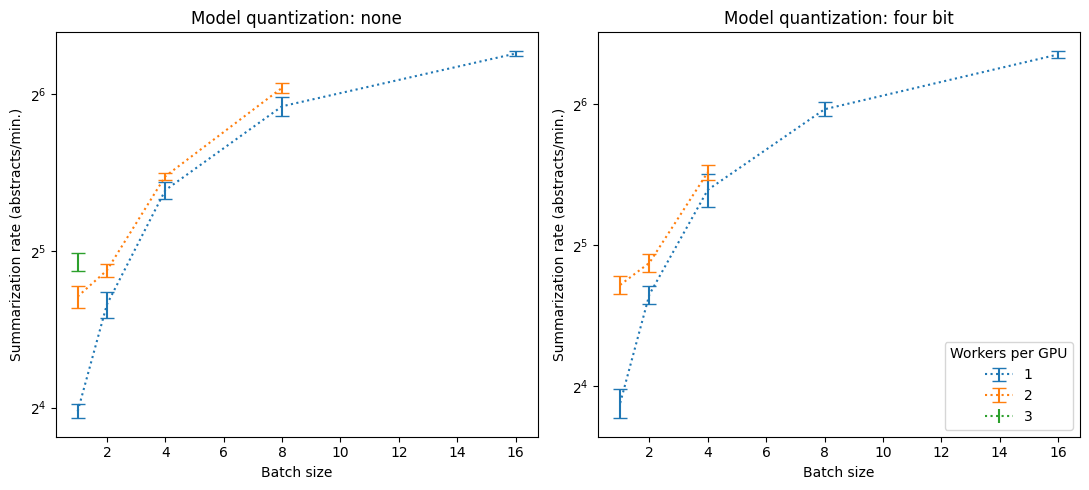

,abstracts,batches,replicate,batch size,workers,jobs per GPU,quantization,summarization time (sec.),summarization rate (abstracts/sec.),summarization rate (abstracts/min.)
0,3,3,1,1,4,1,none,44.361511,0.270505,16.230286
1,3,3,2,1,4,1,none,44.567701,0.269253,16.155197
2,3,3,3,1,4,1,none,45.939972,0.261210,15.672626
3,3,3,4,1,4,1,none,47.880006,0.250627,15.037592
4,3,3,5,1,4,1,none,46.191195,0.259790,15.587386


In [19]:
def parallel_batched_summarization_plot(datafile):

    data = pd.read_csv(datafile)

    OOM_columns = [
        'summarization time (sec.)',
        'summarization rate (abstracts/sec.)'
    ]

    OOM = data[data['summarization time (sec.)'] == 'OOM']
    OOM = OOM[['batch size', 'workers', 'quantization']]
    OOM_conditions = OOM.to_numpy().tolist()

    for OOM_column in OOM_columns:
        for condition in OOM_conditions:

            data[OOM_column].loc[
                (data['batch size'] == condition[0]) &
                (data['workers'] == condition[1]) &
                (data['quantization'] == condition[2])
            ] = np.nan

    data.dropna(inplace=True)

    data['summarization time (sec.)'] = data['summarization time (sec.)'].astype(float)
    data['summarization rate (abstracts/sec.)'] = data['summarization rate (abstracts/sec.)'].astype(float)

    data['summarization rate (abstracts/min.)'] = data['summarization rate (abstracts/sec.)'] * 60
    data['jobs per GPU'] = data['workers'] // 4

    quantization_types = data['quantization'].unique()
    worker_nums = data['jobs per GPU'].unique()

    fig, axs = plt.subplots(1, 2, figsize=(((len(quantization_types) * 5) + 1), 5), tight_layout=True)

    axs_count = 0

    for quantization in quantization_types:
        quantization_type_data = data[data['quantization'] == quantization].copy()
        quantization_type_data.drop('quantization', axis=1, inplace=True)

        for workers in worker_nums:

            plot_data = quantization_type_data[quantization_type_data['jobs per GPU'] == workers]

            mean = plot_data.groupby(['batch size']).mean()
            mean.reset_index(inplace=True)
            
            std = plot_data.groupby(['batch size']).std()
            std.reset_index(inplace=True)

            axs[axs_count].set_title(f'Model quantization: {quantization}')
            axs[axs_count].set_xlabel('Batch size')
            axs[axs_count].set_ylabel('Summarization rate (abstracts/min.)')
            axs[axs_count].set_yscale('log', base=2)
            axs[axs_count].xaxis.set_major_formatter(FormatStrFormatter('%.0f'))

            axs[axs_count].errorbar(
                mean['batch size'], 
                mean['summarization rate (abstracts/min.)'], 
                yerr=std['summarization rate (abstracts/min.)'],
                capsize=5,
                label=workers,
                linestyle='dotted'
            )

        axs_count += 1

    plt.legend(loc='lower right', title='Workers per GPU')

    return data, plt

data, plt = parallel_batched_summarization_plot('../benchmarks/parallel_batched_summarization/results.csv')

plt.show()
data.head()

### 6. SQL Insert

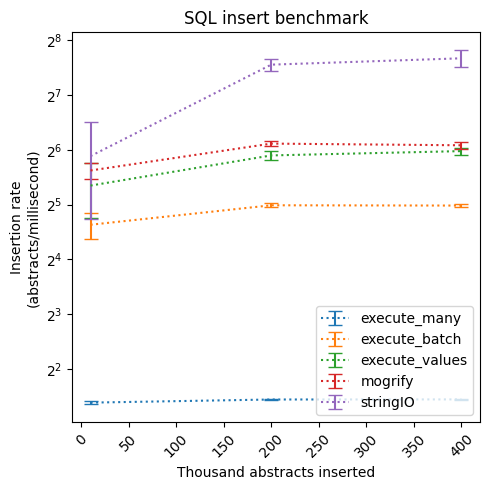

,abstracts,insert time (sec.),insert rate (abstracts/sec.),insert strategy,replicate,insert rate (abstracts/millisecond),thousand abstracts
0,10000,3.772693,2650.626378,execute_many,1,2.650626,10.0
1,10000,3.846135,2600.012807,execute_many,2,2.600013,10.0
2,10000,3.810965,2624.007263,execute_many,3,2.624007,10.0
3,10000,3.817579,2619.461488,execute_many,4,2.619461,10.0
4,10000,3.909431,2557.916853,execute_many,5,2.557917,10.0


In [24]:
def sql_insert_plot(datafile):

    data = pd.read_csv(datafile)
    data['insert rate (abstracts/millisecond)'] = data['insert rate (abstracts/sec.)'] / 1000
    data['thousand abstracts'] = data['abstracts'] / 1000

    insert_strategies = ['execute_many', 'execute_batch', 'execute_values', 'mogrify', 'stringIO']

    fig, axs = plt.subplots(1, 1, figsize=(5, 5), tight_layout=True)

    axs.set_title('SQL insert benchmark')
    axs.set_xlabel('Thousand abstracts inserted')
    axs.set_ylabel('Insertion rate\n(abstracts/millisecond)')
    axs.set_yscale('log', base=2)
    axs.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
    axs.tick_params(axis='x', labelrotation=45)

    for insert_strategy in insert_strategies:

        plot_data = data[data['insert strategy'] == insert_strategy]

        mean = plot_data.groupby(['insert strategy', 'thousand abstracts']).mean()
        mean.reset_index(inplace=True)
        
        std = plot_data.groupby(['insert strategy', 'thousand abstracts']).std()
        std.reset_index(inplace=True)

        axs.errorbar(
            mean['thousand abstracts'], 
            mean['insert rate (abstracts/millisecond)'], 
            yerr=std['insert rate (abstracts/millisecond)'],
            capsize=5,
            label=insert_strategy,
            linestyle='dotted'
        )

    plt.legend(loc='lower right')

    return data, plt

data, plt = sql_insert_plot('../benchmarks/sql_insert/results.csv')

plt.show()
data.head()